In [92]:
# Analyse de données
import pandas as pd
import numpy as np
from datetime import datetime
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
# Standardisation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Découpage du dataset
from sklearn.model_selection import train_test_split
# Modélisation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
# métriques
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Historique
import os 

In [93]:
DATA_PATH = 'data/carData_cleaned.csv'

df = pd.read_csv(DATA_PATH)

## Nettoyage et préparation des données

In [94]:
# Ajout de la variable âge : Car_Age
current_year = datetime.now().year
df['Car_Age'] = current_year - df['Year']

# Stratification de 'Selling_Price' en 'Price_Category'
df['Price_Category'] = np.ceil(df['Selling_Price'] /1.5)
df['Price_Category'] = df['Price_Category'].where(df['Price_Category'] <5, 5.0)

# Standardisation de : Present_Price, Kms_Driven, Car_Age
scaler = StandardScaler()
df[['Present_Price_Std', 'Kms_Std', 'Car_Age_Std']] = scaler.fit_transform(df[['Present_Price', 'Kms_Driven', 'Car_Age']])

# Conversion des variables qualitatives en variables quantitatives
df["Fuel_Type_numeric"] = df["Fuel_Type"].map({"Petrol": 1, "Diesel": 2, "CNG": 3})
df["Seller_Type_numeric"] = df["Seller_Type"].map({"Dealer": 1, "Individual": 2})
df["Transmission_numeric"] = df["Transmission"].map({"Manual": 0, "Automatic": 1})

# DataFrame filtré BRUT
df_filtered = df[['Car_Age', 'Selling_Price', 'Price_Category', 'Present_Price', 'Kms_Driven', "Fuel_Type_numeric", "Seller_Type_numeric", "Transmission_numeric"]]
# DataFrame filtré STANDARDISE
df_std = df[['Car_Age_Std', 'Selling_Price', 'Price_Category', 'Present_Price_Std', 'Kms_Std', "Fuel_Type_numeric", "Seller_Type_numeric", "Transmission_numeric"]]

## Selection des Features et de Target

In [95]:
# features
X = df_std.drop(['Selling_Price'], axis=1)

# Target
y = df_std['Selling_Price']

## Division du dataset : jeu d'entrainement, jeu de test

In [96]:
# DIVISION STANDARD
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [99]:

# STRATIFICATION
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_std, df_std['Price_Category']):
    strat_train = df_std.loc[train_index]
    strat_test = df_std.loc[test_index]

# DIVISION
X_train = strat_train.drop(["Selling_Price", "Price_Category"], axis=1)
y_train = strat_train["Selling_Price"]

X_test = strat_test.drop(["Selling_Price", "Price_Category"], axis=1)
y_test = strat_test["Selling_Price"]

In [100]:
print("Nombre d'observations : ", len(df),"\n")
print("Nombre d'observations par tranche : ", df["Price_Category"].value_counts(),"\n")
print("Ratio par tranche : ", df["Price_Category"].value_counts() / len(df))

Nombre d'observations :  251 

Nombre d'observations par tranche :  Price_Category
1.0    85
5.0    56
4.0    46
3.0    37
2.0    27
Name: count, dtype: int64 

Ratio par tranche :  Price_Category
1.0    0.338645
5.0    0.223108
4.0    0.183267
3.0    0.147410
2.0    0.107570
Name: count, dtype: float64


## Entrainement du modèle

In [101]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

## Prédiction

In [102]:
# Prédictions sur le set de test
y_pred = lin_reg.predict(X_test)

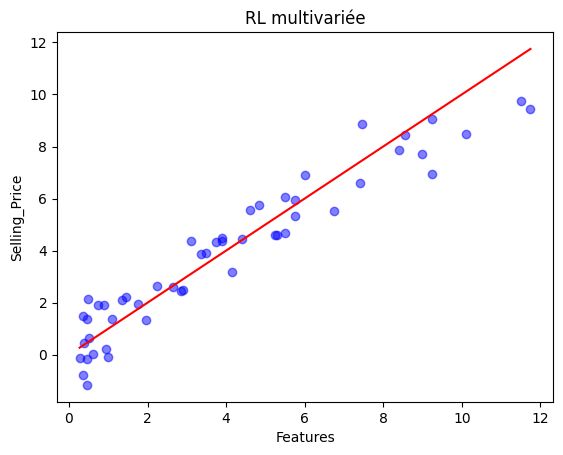

In [103]:
plt.title("RL multivariée")
plt.scatter(y_test, y_pred, color="blue", alpha=0.5)
plt.xlabel("Features")
plt.ylabel("Selling_Price")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red")  # Ligne parfaite



## Métriques

In [104]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f" MAE: {mae}\n MSE: {mse}\n RMSE: {rmse}\n R2: {r2}")



 MAE: 0.798404065205117
 MSE: 0.920315535731569
 RMSE: 0.9593307749319674
 R2: 0.9114792946747176


In [ ]:
# Création d'une ligne de résultat
new_result = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "dataset": DATA_PATH,
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
}

# Nom du fichier CSV
file_path = "historique_tests_regression.csv"

# S'il existe déjà, on charge et on ajoute la nouvelle ligne
if os.path.exists(file_path):
    results_df = pd.read_csv(file_path)
    results_df = results_df.append(new_result, ignore_index=True)
else:
    # Sinon, on crée un nouveau DataFrame
    results_df = pd.DataFrame([new_result])

# Sauvegarde mise à jour
results_df.to_csv(file_path, index=False)

# Affiche les résultats mis à jour
print(results_df.tail())



              datetime                   dataset  ...      RMSE        R2
0  2025-04-04 14:48:15  data/carData_cleaned.csv  ...  1.017695  0.856869

[1 rows x 6 columns]


Avant stratification du jeu d'entrainement :<br>
 MAE: 0.7268192681776056<br>
 MSE: 1.0357039723016037<br>
 RMSE: 1.0176954221679508<br>
 R2: 0.8568691779502842<br>